In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import dill as pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=16)
from popsed import prior

In [3]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)

noise = 'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [4]:
X_data = np.load('./NDE/GAMA/NMF/mock_mags_gama_apmatch_noise.npy')[:, :5]
print('Total number of samples:', len(X_data))

Total number of samples: 70000


In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [6]:
_prior_NDE = speculator.bounds.copy()

_prior_NDE[-2] = np.array([0., 0.8])
_prior_NDE[-1] = np.array([7.5, 13.])
# _prior_NDE[-4] = np.array([0., 2.])

`lr3e-4_ann7p5_30_30t` is bad

`lr3e-4_ann7p5_30` is better

`lr3e-4_ann7p5_40` is not better than 30 epoches

`lr3e-4_ann6_30` is not better than ann7p5

In [99]:
nde_dir = './NDE/GAMA/anneal/mock2/lr4e-4_ann12_zscore_50e/'
filelist = os.listdir(nde_dir)
# nde_dir = './NDE/GAMA/anneal/mock2/lr3e-4_ann12_zscore_40e/'
# filelist += os.listdir(nde_dir)

# filelist = [file for file in filelist if 'nde_theta_best' in file]
# ind = [int(file.replace('nde_theta_best_loss_nsf_', '').strip('.pkl')) for file in filelist]


filelist = [file for file in filelist if 'nde_theta_last' in file]
ind = [int(file.replace('nde_theta_last_model_nsf_', '').strip('.pkl')) for file in filelist]

# filelist = np.array(filelist)[np.array(ind) > 10]

# filelist = np.array(filelist)[(np.array(ind) > 30)]
# filelist = ['nde_theta_best_loss_nsf_20.pkl',
#             'nde_theta_best_loss_nsf_31.pkl',
#             'nde_theta_best_loss_nsf_25.pkl', 
#             'nde_theta_best_loss_nsf_35.pkl']

In [100]:
len(filelist)

4

(0.0, 0.6)

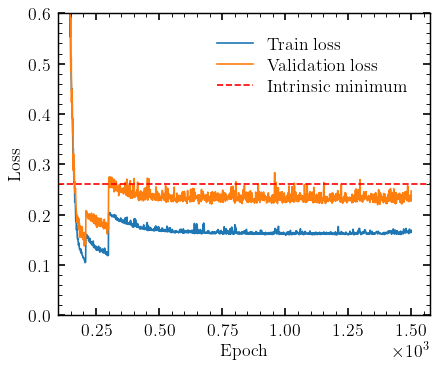

In [87]:
NDE.plot_loss(0.26)
plt.xlim(100)
plt.ylim(0, 0.6)

In [101]:
# This is slow
NDE_list = []
for file in filelist[:]:
    try:
        NDE = pickle.load(open(os.path.join(nde_dir, file), 'rb'))
        del NDE.X
        del NDE.X_vali
        del NDE.batch_theta
#         NDE_list.append(NDE)
        if np.mean(NDE.vali_loss_history[-20:]) < 1.5:
            NDE_list.append(NDE)
#             pass
        else:
            print('Poor vali loss for', file)
#             print('Remove', file)
    except Exception as e:
        print(file, e)
        continue

In [102]:
### score for each model is vali_loss

In [103]:
vali_loss = np.array([np.mean(NDE.vali_loss_history[-30:]) for NDE in NDE_list])
print(np.mean(vali_loss))
vali_loss

0.23397625920673212


array([0.23553965, 0.23264456, 0.23500186, 0.23271897])

In [104]:
vali_loss = np.array([np.mean(NDE.train_loss_history[-30:]) for NDE in NDE_list])
print(np.mean(vali_loss))
vali_loss

0.1640981419632832


array([0.16417298, 0.16343077, 0.16467563, 0.16411318])

In [105]:
score = np.min(vali_loss) / vali_loss
score

array([0.99547912, 1.        , 0.99244052, 0.99584183])

(100.0, 1573.95)

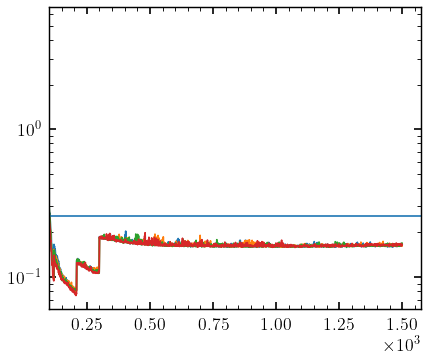

In [106]:
[plt.plot(NDE.train_loss_history) for NDE in np.array(NDE_list)[np.argsort(vali_loss)][:]]
plt.yscale('log')

plt.axhline(0.26)
plt.xlim(100)

In [107]:
torch.cuda.empty_cache()

### Show each NDE

In [108]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

from popsed.nde import inverse_transform_nmf_params_given_mass

In [109]:
_samples_unt = []
_samples = []
for NDE in [NDE_list[i] for i in np.argsort(vali_loss)[:]]:
    _samp = inverse_transform_nmf_params(NDE.sample(5000), _prior_NDE).cpu().detach().numpy()
    
    _samples_unt.append(_samp)
    _samples.append(np.hstack([_samp[:, -1:], 
                   prior.FlatDirichletPrior(4).transform(_samp[:, :3]), 
                   _samp[:, 3:-1]]))
_samples_unt = np.dstack(_samples_unt)
_samples = np.dstack(_samples)

In [110]:
# _spl = _samples_unt.swapaxes(0, 1).reshape(_samples_unt.shape[1], -1).T

In [66]:
# np.save('./NDE/GAMA/NMF/z_mass_mock.npy', _spl[:, -2:])

In [82]:
import corner

In [83]:
true_params_unt = np.load('./NDE/GAMA/NMF/mock_params.npy')
true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 10000)]
true_params = np.hstack([prior.FlatDirichletPrior(4).transform(true_params_unt[:, :3]),
                      true_params_unt[:, 3:-1], 
                      true_params_unt[:, -1:]])

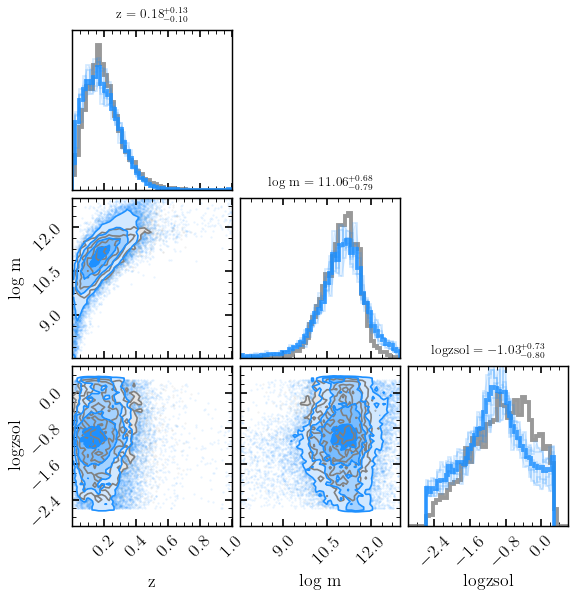

In [89]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=45,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 13], [-3, 0.6]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], _samples_unt[:, -1:], _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=45,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

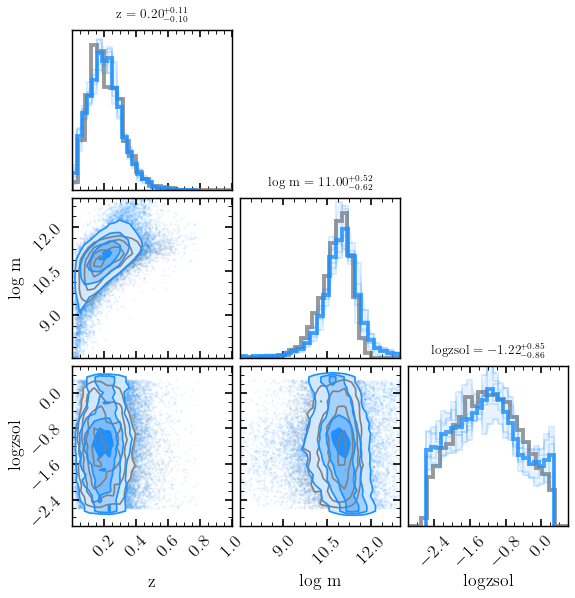

In [64]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 13], [-3, 0.6]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], 
                                  _samples_unt[:, -1:], 
                                  _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

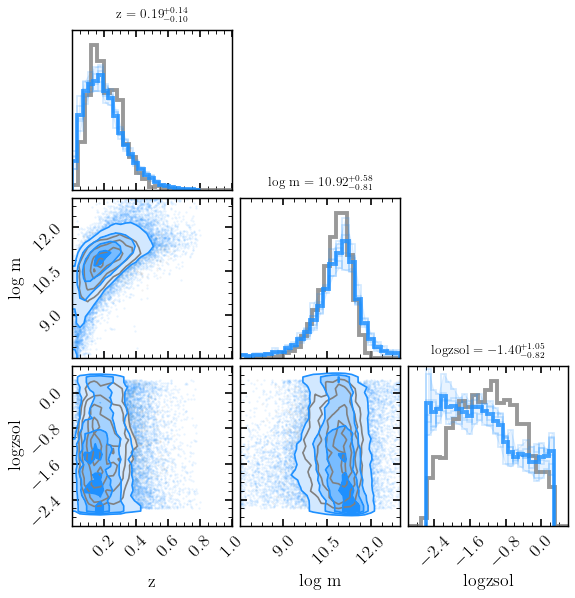

In [73]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 13], [-3, 0.6]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], 
                                  _samples_unt[:, -1:], 
                                  _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

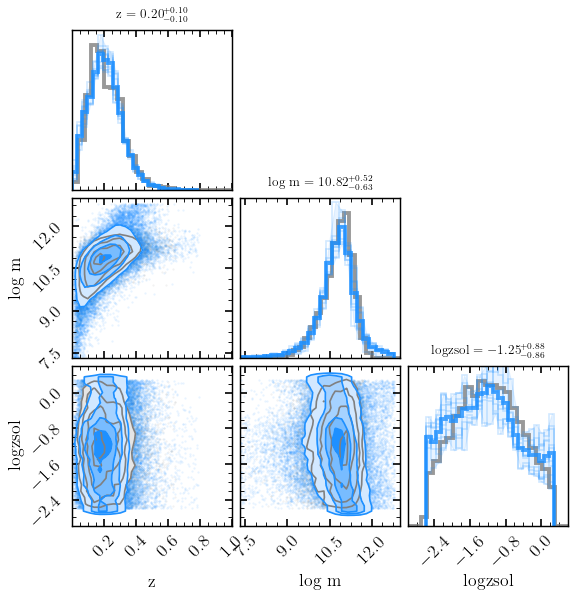

In [126]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 13], [-3, 0.6]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], 
                                  _samples_unt[:, -1:] - 0.2, 
                                  _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

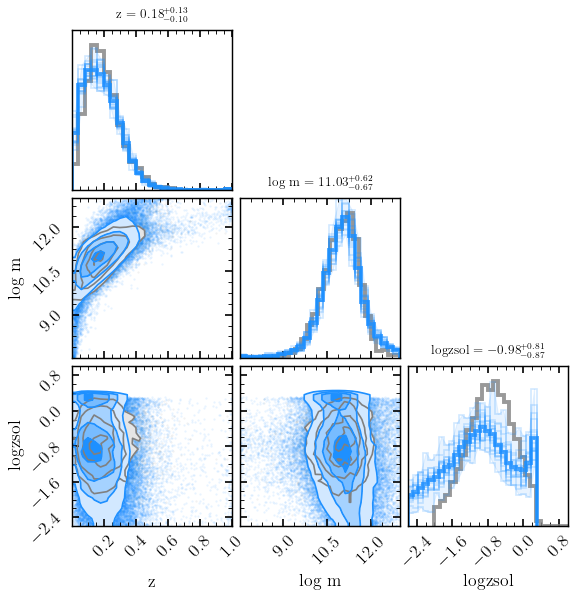

In [21]:
z_mass_met = np.hstack([true_params[:, -2:], true_params[:, 6:7]])
figure = corner.corner(z_mass_met, 
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 13], [-2, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], _samples_unt[:, -1:], _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['z', 'log m', 'logzsol'], bins=25,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [121]:
y_truth_trans[:, -1] -= 0.2

Text(0.5, 1.02, 'Noisy model + noisy data')

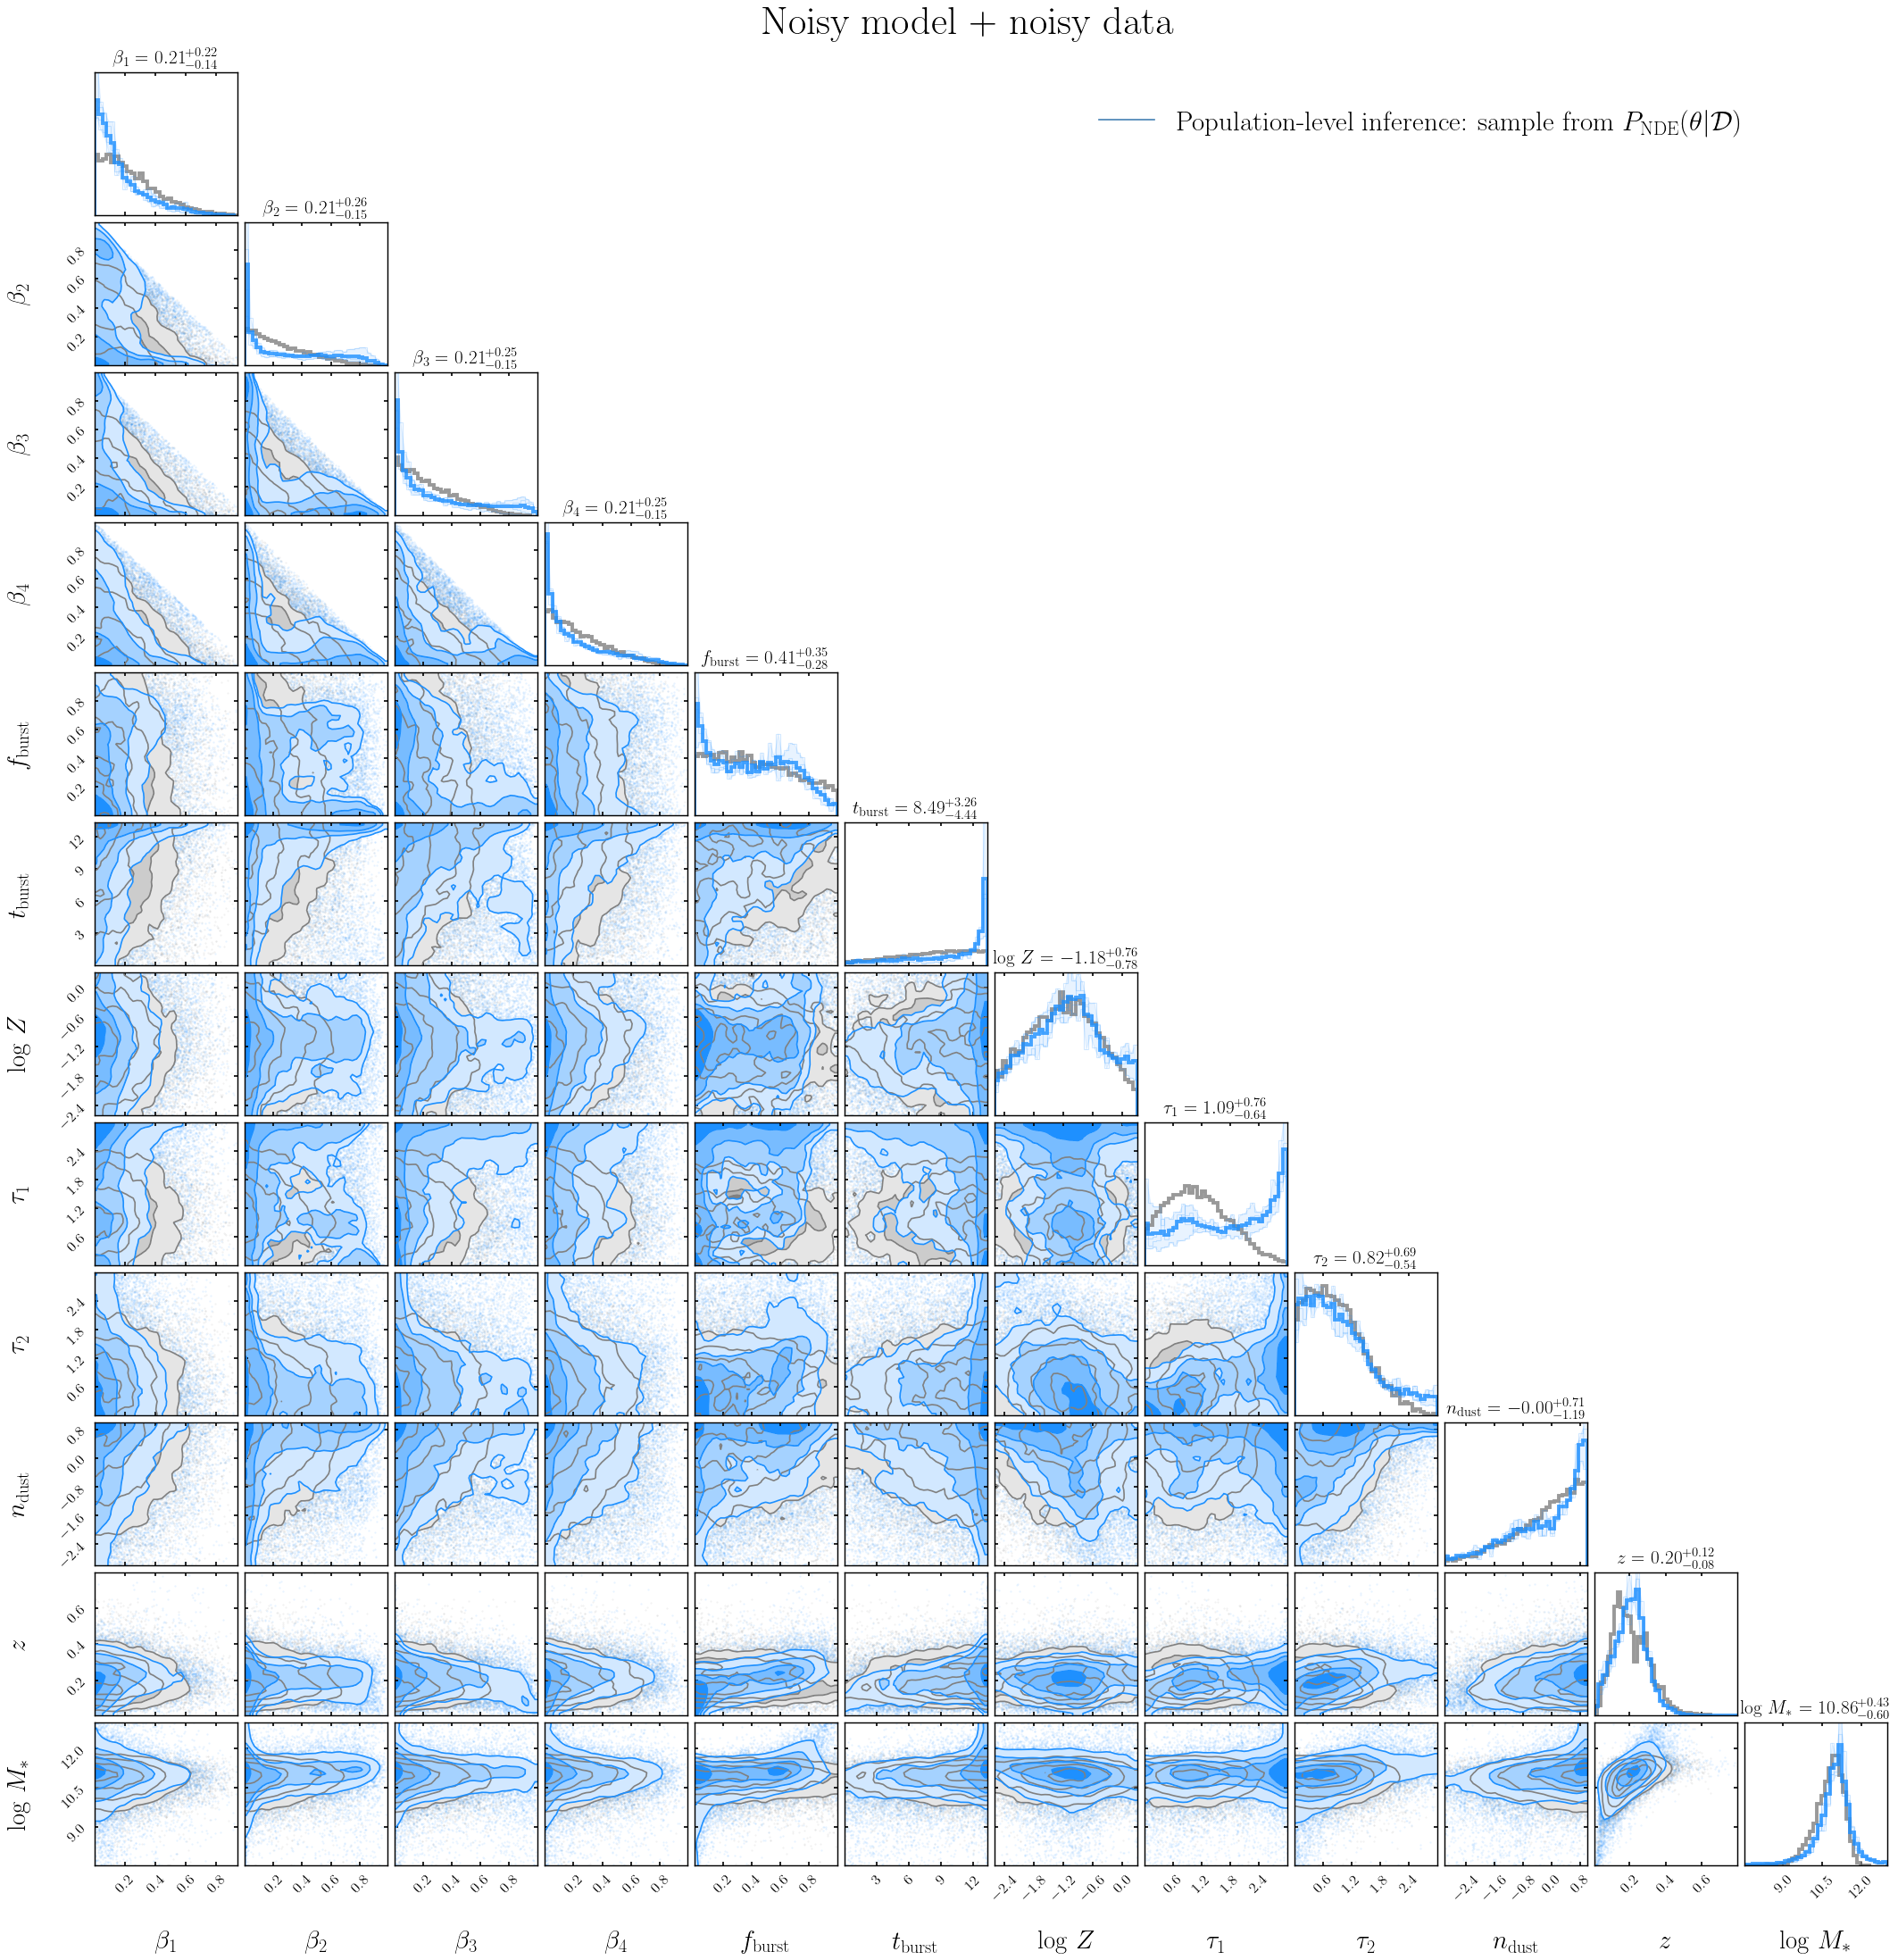

In [111]:
import matplotlib.lines as mlines
# k_line = mlines.Line2D([], [], color='k', label='Parameters for mock observation')
b_line = mlines.Line2D([], [], color='steelblue', 
                       label=r'Population-level inference: sample from $P_{\mathrm{NDE}}(\theta|\mathcal{D})$')

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

if name == 'NMF_ZH':
    labels = labels[:6] + [r'$\gamma_{1}$', r'$\gamma_{2}$'] + labels[7:]

# if name == 'NMF_ZH':
#     figure, axes = plt.subplots(13, 13, figsize=(20, 20))
# else:
#     figure, axes = plt.subplots(12, 12, figsize=(20, 20))
    
figure = corner.corner(true_params, 
      labels=labels, bins=35,
      color='gray', # quantiles=[0.16, 0.5, 0.84], 
      smooth=1.0, fill_contours=True,
      show_titles=True, title_kwargs={"fontsize": 19}, 
            hist_kwargs={'density': True}, plot_datapoints=True)

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])
figure = corner.corner(
    y_truth_trans,
    fig=figure,
    color='dodgerblue',
    labels=labels,
#     range=[[0, 1], [0, 1], [0., 1], [0, 1], [-0.02, 1.02], [0.5, 13], 
#            [-2.5, 0.3], [0, 3], [0, 1.6], [-2, 1], [0, 0.06], [8, 12]],
    bins=35,
    smooth=1.0,
    fill_contours=True,
    show_titles=False,
    title_kwargs={'fontsize': 19},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True, 'lw': 1},
#     plot_datapoints=False
    )

for ax in figure.get_axes():
    ax.tick_params(labelsize=15, length=4)
    ax.minorticks_off()

ax = figure.get_axes()[10]
ax.legend(handles=[b_line],  # k_line, 
          fontsize=28, 
          bbox_to_anchor=(0., 1.0, 1.3, .0))

plt.suptitle('Noisy model + noisy data', fontsize=40, y=1.02)

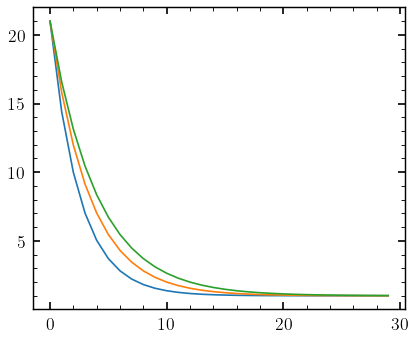

In [113]:
plt.plot([1 + 20 * np.exp(- 12 / 30 * i)
                for i in range(30)])

plt.plot([1 + 20 * np.exp(- 9 / 30 * i)
                for i in range(30)])

plt.plot([1 + 20 * np.exp(- 7.5 / 30 * i)
                for i in range(30)])

In [41]:
# del _samples
# import gc
# gc.collect()

0 5000
>30 0


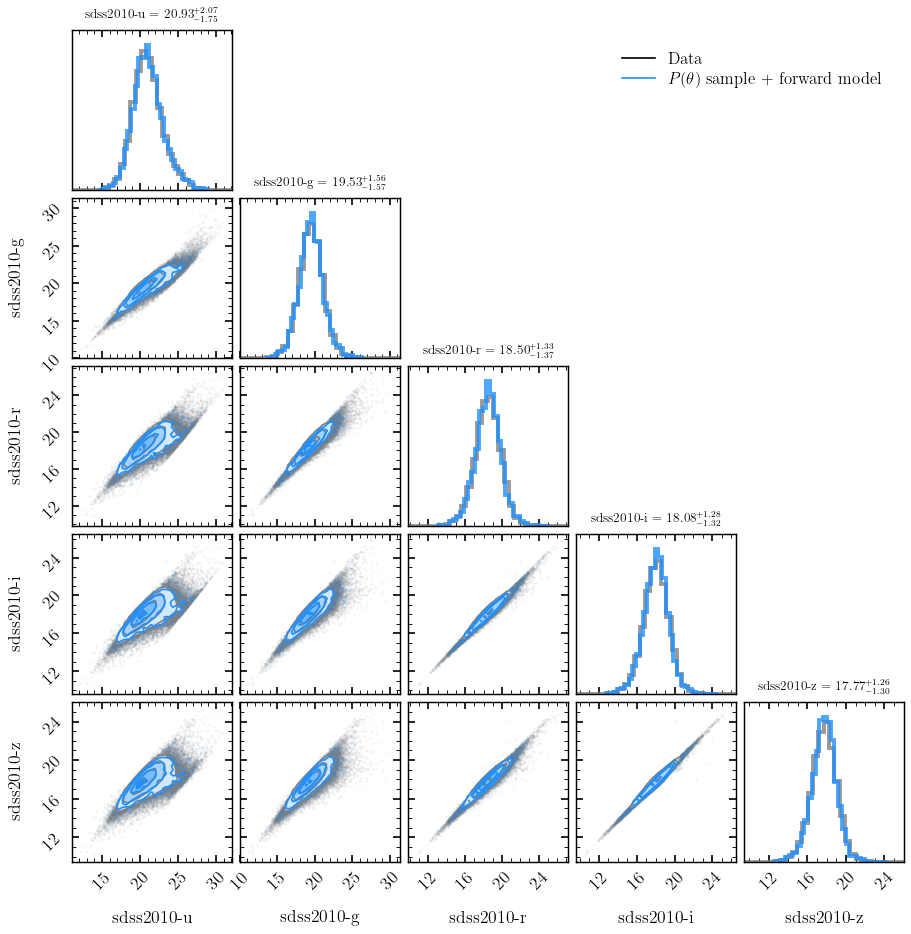

In [42]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [filt.replace('_', '\_') for filt in gama_filters]

figure = corner.corner(X_data, 
                       color='gray', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

_spl = _samples_unt.swapaxes(0, 1).reshape(_samples_unt.shape[1], -1).T
# _spl = torch.Tensor(_spl).to('cuda')
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 5000)]).to('cuda')
# _z = torch.Tensor(np.random.choice(NDE.external_redshift_data, len(_spl))[
#     :, None]).to(NDE.device)
# _spl = torch.hstack([_spl[:, :-1], _z, _spl[:, -1:]])


mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 15}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

---
### Calculate average age and SFR

In [69]:
if name == 'NMF_ZH':
    from popsed.models import NMF_ZH
    model = NMF_ZH(burst=True, peraa=True)
else:
    from popsed.models import NMF
    model = NMF(burst=True, peraa=True)

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index


In [70]:
params = _samples.swapaxes(0, 1).reshape(_samples.shape[1], -1).T
params = torch.Tensor(params[np.random.randint(0, len(params), 5000)]).detach().cpu().numpy()

In [71]:
sfr = np.zeros(len(params))
age = np.zeros(len(params))

for i in range(len(params)):
    tt = params[i]
    sfr[i] = model.avgSFR(tt[:-1], zred=float(tt[-1]), dt=1)
    age[i] = model.tage_MW(tt[:-1], zred=float(tt[-1]))
    
if name == 'NMF_ZH':
    zmw = np.zeros(len(params))
    for i in range(len(params)):
        tt = params[i]
        zmw[i] = model.Z_MW(tt[:-1], zred=float(tt[-1]))
        
if name == 'NMF_ZH':
    logzsol = np.log10(zmw / 0.019)
else:
    logzsol = params[:, 7]
redshift = params[:, -1]

In [72]:
logmstar = params[:, 0]

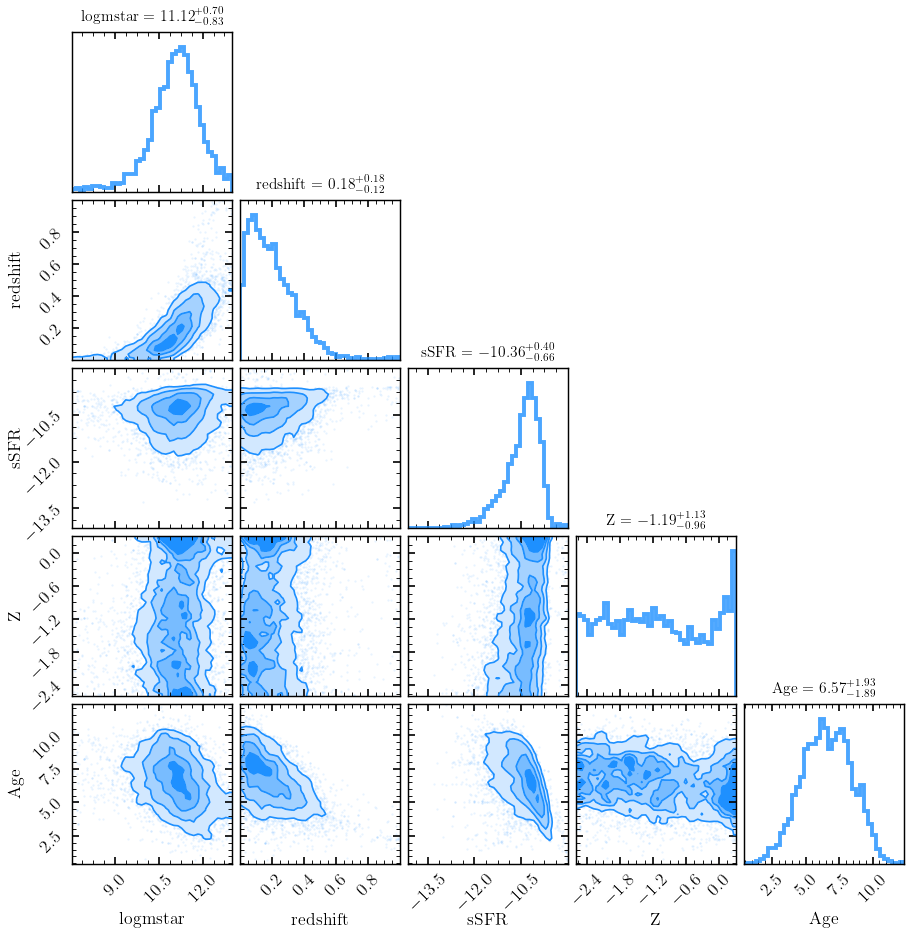

In [74]:
figure = corner.corner(np.vstack([logmstar, redshift, np.log10(sfr) - logmstar, logzsol, age]).T, 
                  labels=['logmstar', 'redshift', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.8, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

In [159]:
logmstar = _spl[:, 0]
logzsol = _spl[:, 7]
u_r = mags[:, 0] - mags[:, 2]

Text(0, 0.5, 'sSFR [Gyr$^{-1}$]')

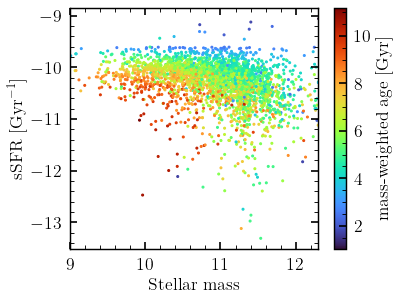

In [129]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(logmstar, np.log10(sfr) - logmstar, c=age, s=3)

plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='mass-weighted age [Gyr]')
plt.xlabel('Stellar mass')
plt.ylabel('sSFR [Gyr$^{-1}$]')

Text(0, 0.5, 'Age [Gyr]')

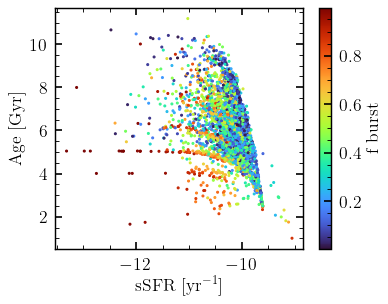

In [150]:
fig, ax = plt.subplots(figsize=(5, 4))

plt.scatter(np.log10(sfr) - logmstar, age, c=_spl[:, 5], s=3)

# plt.xlim(9, 12.3)
# plt.ylim(-13, -8)

plt.colorbar(label='f burst')
plt.xlabel('sSFR [yr$^{-1}$]')
plt.ylabel('Age [Gyr]')

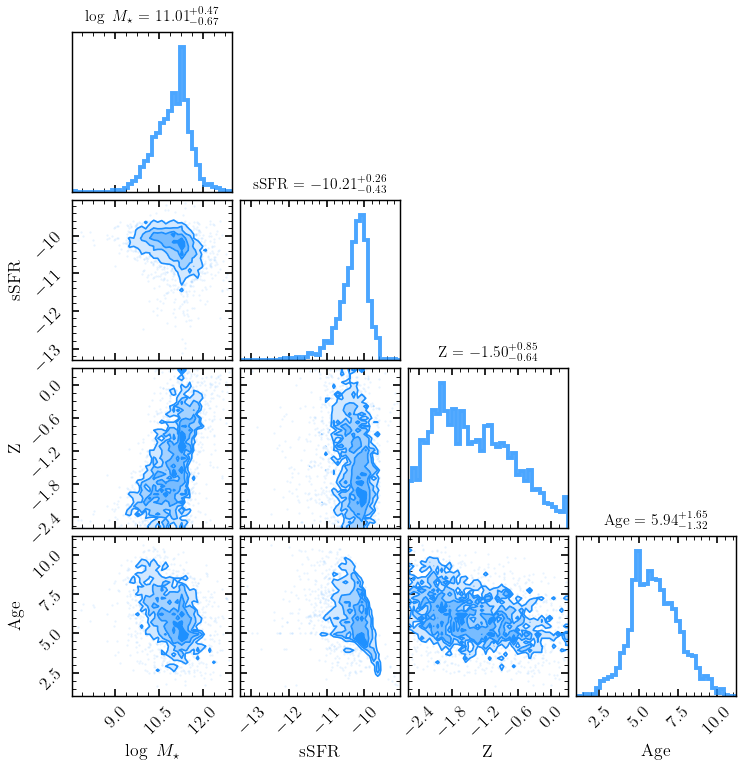

In [161]:
figure = corner.corner(np.vstack([logmstar, np.log10(sfr)-logmstar, logzsol, age]).T, 
                  labels=['$\log\ M_\star$', 'sSFR', 'Z', 'Age'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.3, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

# ax = figure.get_axes()[2]
# ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

In [29]:
tt = _samples[..., 0][0:1]
tage = model.cosmo.age(tt[:, -1:]).value # convert redshift to age
theta = model._parse_theta(tt[:, :-1])

Text(0, 0.5, 'SFR [Msun/yr] (normalized to 1 Msun)')

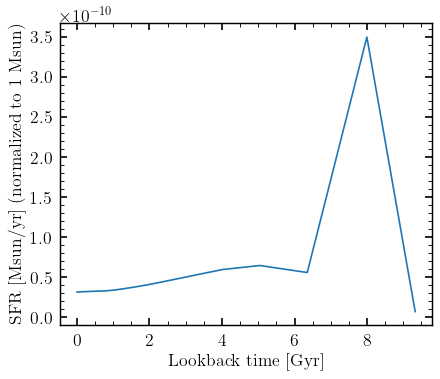

In [37]:
# Display SFH
tlb_edges, sfh = model.SFH(np.hstack([np.zeros(len(tt))[:, None], tt[:, 1:-1]]), zred=tt[:, -1][0], _burst=True)
plt.plot(0.5 * (tlb_edges[1:] + tlb_edges[:-1]), sfh)
plt.xlabel('Lookback time [Gyr]')
plt.ylabel('SFR [Msun/yr] (normalized to 1 Msun)')

In [73]:
sfrs = []
for tt in _samples[..., 0][0:1000]:
    sfrs.append(model.avgSFR(tt[:-1], zred=tt[-1], dt=1))
    
sfrs = np.array(sfrs).ravel()

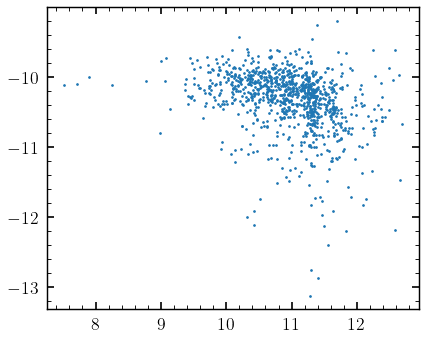

In [79]:
plt.scatter(_samples[..., 0][0:1000][:, 0], np.log10(sfrs) - _samples[..., 0][0:1000][:, 0], s=2)

In [80]:
model.tage_MW(tt[:-1], zred=tt[-1])

array([5.01615946])

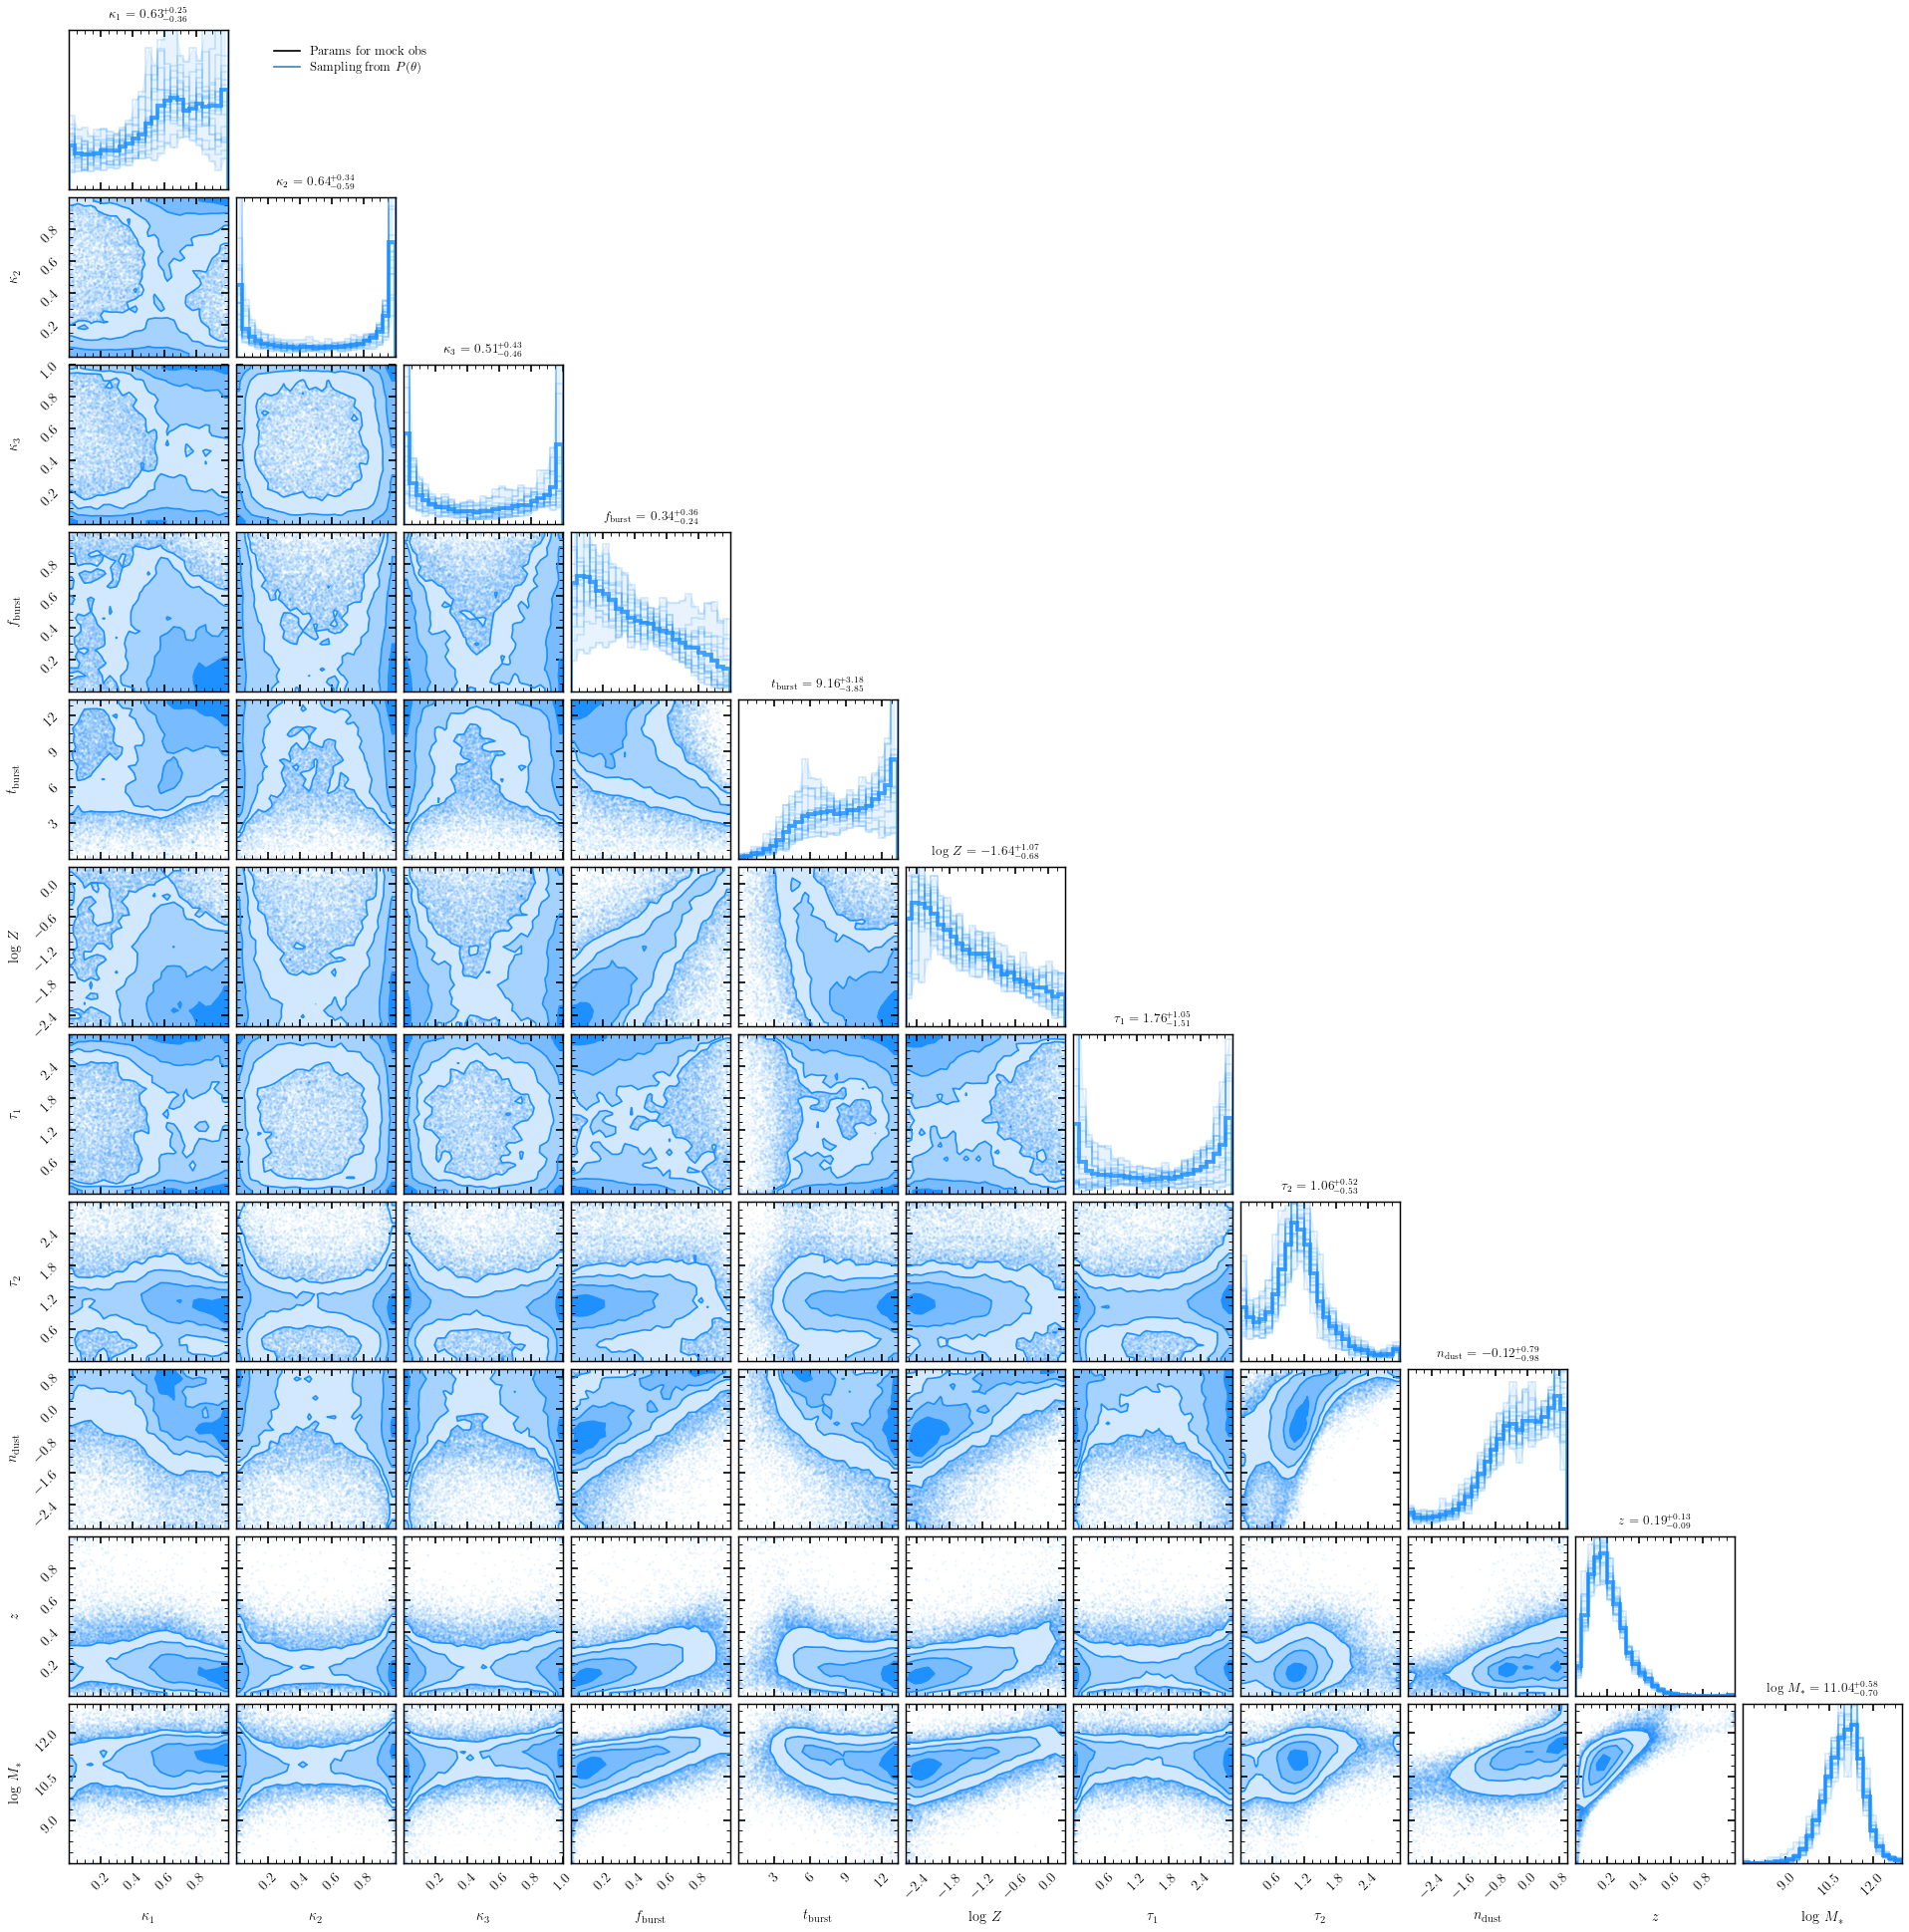

In [58]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [
    r'$\kappa_{1}$',
    r'$\kappa_{2}$',
    r'$\kappa_{3}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

figure = corner.corner(_samples_unt, 
                  labels=labels, bins=25,
                  color='dodgerblue',
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = figure.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))